Эти материалы сделаны для актуализации представлений о том, как работают нейронные сети на примере классификации простых объектов. В качестве ключевого модуля будет исопользоваться torch.

Материал подготовлен на основе этой [публикации](https://habr.com/ru/articles/553716/).

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import copy
import datetime as dt
import pandas as pd
import numpy as np

## Генерация данных для обучения

Для создания данных будет использоваться модуль sklearn. После создания выборки, разделим её на две части и визуализируем для примера.

In [ ]:
X, y = make_moons(n_samples=150, random_state=33, noise=0.2)

In [ ]:
df = pd.DataFrame(X, columns=['x1', 'x2'])
df['target'] = y
df.head(5)

,x1,x2,target
0,0.528470,-0.353776,1
1,-0.968172,0.134251,0
2,0.030177,0.961802,0
3,-0.463210,0.997252,0
4,1.854772,0.152242,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=33)

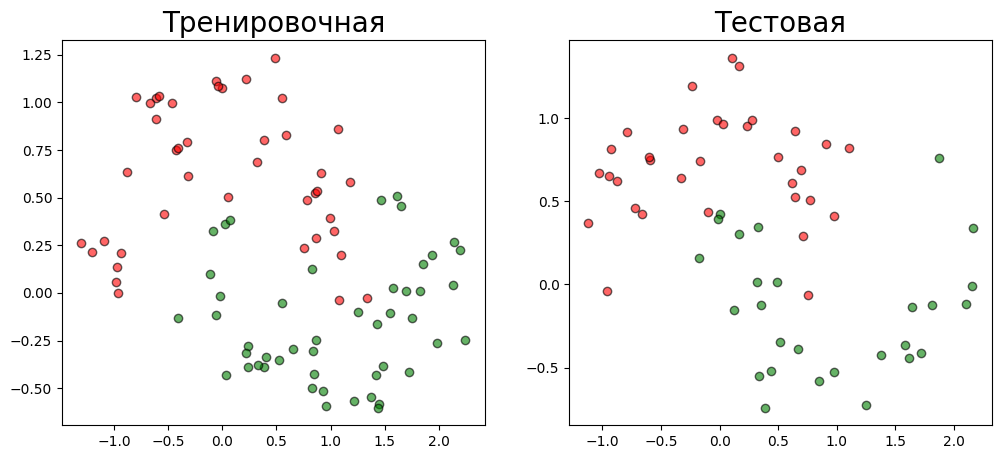

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.scatter(X_train[:,0][y_train == 0], X_train[:,1][y_train == 0], c='red', marker='o', edgecolors = 'black', alpha = 0.6)
ax1.scatter(X_train[:,0][y_train == 1], X_train[:,1][y_train == 1], c='green', marker = 'o', edgecolors = 'black', alpha = 0.6)
ax1.set_title('Тренировочная', fontsize=20)

ax2.scatter(X_test[:,0][y_test == 0], X_test[:,1][y_test == 0], c='red', marker='o', edgecolors = 'black', alpha = 0.6)
ax2.scatter(X_test[:,0][y_test == 1], X_test[:,1][y_test == 1], c='green', marker = 'o', edgecolors = 'black', alpha = 0.6)
ax2.set_title('Тестовая', fontsize=20);

### Подготовка данных

Для удобства дальнешей работы создадим класса Dataset, переопределив методы _len_ и _getitem_.

In [ ]:
class MyDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

## Создание нейронной сети

Создадим простую нейронную сеть с тремя слоями. В качестве функций активации будем использовать ReLU и Sigmoid в конце. Сигмоида преобразует итоговые значения к интервалу [0;1].


In [ ]:
import torch.nn as nn

ReLU = nn.ReLU()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = ReLU(self.fc1(x))
        x = ReLU(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x.view(-1)

In [ ]:
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)


### О том, что такое нейрон

Нейронная сеть состоит из нейронов, которые представляют собой простые математические функции с сумматором "под капотом".
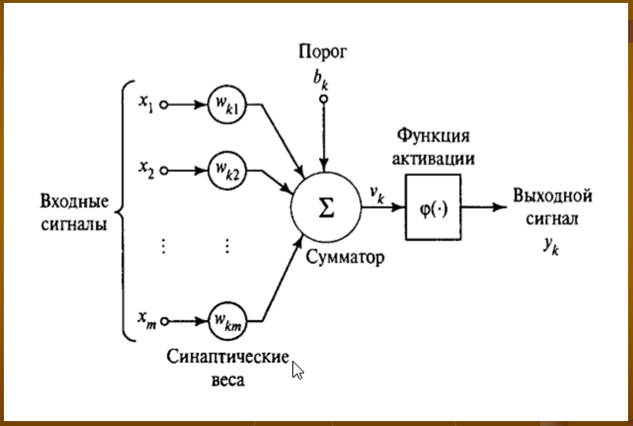

$x_1, x_2, ..., x_n$ - входные сигналы, представленные любыми числовыми значениями \
$w_1, w_2, ..., w_n$ - веса входных сигналов, представленные также любыми числовыми значениями - **настраиваемый параметр, которые требует обучения** \
$b$ - сдвиг, единичное числовое значение - **настраиваемый параметр, который требует обучения**  \


Произведение сигналов на веса с добавлением сдвига складываются и передаются в функцию активация, которая может быть любой математической функцией. Результат может быть использован любым образом.

Таким образом, нейрон принимает на вход любое количество чисел, а на выходе всегда имеет только одно число.

Общая формула выглядит так: \
$  f(\sum_{i=1}^{n}w_i*x_i + b)$

Обычно, как и в случае с линейной регрессией, для упроещния матричных вычислений сдвигу ставят в соответствие некторый "искусственный" входной сигнал $x_0 = 1$, а значение сдвига принимают за "нулевой" вес $w_0$. Таким образом формула приобразуется в \
$  f(\sum_{i=0}^{n}w_i*x_i)$

То есть математический нерон - это просто линейный сумматор.

Так как в задаче, которую мы решаем, поставлен вопрос классификцации, то функция активации последнего нейрона в слое должна быть таковой, чтобы её значения можно было интерпетировать в качестве вероятности отнесения объекта к одному из нескольких классов. Это может достигаться разными путями. Классический вариант для задачи классификации на два класса - сигмоидальная функция или "сигмоимда".

График и формула сигмоиды представлена ниже.

$$ s (x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-x} }  $$


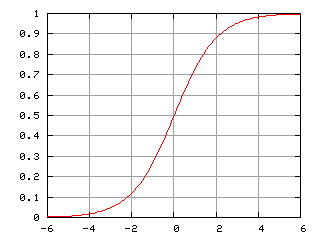

## Создание класса для обучения

Организация обучения промышленной модели требует качественной организации кода (в отличии от организации исследования данных или EDA, где требования к качеству хоть и также высоки, но значительно ниже).

В данной работе для примере мы создадим полный класс, описание параметров и деталей которого, представленно в самом коде.

In [ ]:
class Trainer():
    """
    Parameters:
        dataset: класс, хранящий данные
        loss_f: функция потерь
        learning_rate: величина градиентного шага
        epoch_amount: общее количество эпох
        batch_size: размер одного бача
        max_batches_per_epoch: максимальное количество бачей,
                               подаваемых в модель в одну эпоху
        device: устройство для вычислений
        early_stopping: количество эпох без улучшений до остановки обучения
        optim: оптимизатор
        scheduler: регулятор градиентного шага
        permutate: перемешивание тренировочной выборки перед обучением

    Attributes:
        start_model: необученная модель
        best_model: модель, после обучения
        train_loss: средние значения функции потерь на тренировочных
                    данных в каждой эпохе
        val_loss: средние значения функции потерь на валидационных
                  данных в каждой эпохе

    Methods:
        fit: обучение модели
        predict: возвращает предсказание обученной моделью

    """

    # это классический конструктор класса, он учитывает много различных
    # параметров, часть из которых задаётся по умолчанию
    def __init__(self,  dataset, net, loss_f, learning_rate=1e-3,
                epoch_amount=10, batch_size=12,
                max_batches_per_epoch=None,
                device='cpu', early_stopping=10,
                optim=torch.optim.Adam,
                scheduler=None, permutate=True):

        self.loss_f = loss_f
        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.device = device
        self.early_stopping = early_stopping
        self.optim = optim
        self.scheduler = scheduler
        self.permutate = permutate
        self.dataset = dataset
        self.start_model = net
        self.best_model = net

        self.train_loss = []
        self.val_loss = []

    # метод используется для предсказания значения, выбирает лучшую модель
    # из ранее обученных
    def predict(self, X):
        return self.best_model(X)

    # большой метод для тренировки
    # вообще говоря, его можно было разбить ещё на один метод, описывающий
    # тренировку одно отдельной эпоих
    def fit(self, X_train, X_test, y_train, y_test):

        Net = self.start_model # берём исходную модель

        device = torch.device(self.device)

        Net.to(self.device) # переносим модель на видеокарту

        # задаём оптимизатор
        optimizer = self.optim(Net.parameters(), lr=self.learning_rate)

        # расписание изменения (уменьшения) скорости изменения и его шаг
        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer)

        # создаём из данных dataset и загрузчик
        train = self.dataset(X_train, y_train)
        val = self.dataset(X_test, y_test)

        train = DataLoader(train, batch_size=self.batch_size, shuffle=self.permutate)
        val = DataLoader(val, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf') # Лучшее значение функции потерь на валидационной выборке
                                     # функции потерь на валидационной выборке
        best_ep = 0                  # Эпоха, на которой достигалось лучшее
                                     # значение функции потерь на валидационной выборке

        # начинаем обучение по эпохам
        for epoch in range(self.epoch_amount):
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            Net.train() # переводим сеть в режим обучения
            mean_loss = 0
            batch_n = 0

            # разбиваем данные на признаки и значения
            for batch_X, target in train:
                if self.max_batches_per_epoch is not None:
                    if batch_n >= self.max_batches_per_epoch:
                        break

                # обнуляем градиенты
                optimizer.zero_grad()

                # переносим данные на карточку
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                # предсказываем значения
                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target) # считаем loss
                loss.backward() # считаем градиенты
                optimizer.step() # меняем значения весов

                mean_loss += float(loss)
                batch_n += 1

            mean_loss /= batch_n # считаем средний loss по батчам
            self.train_loss.append(mean_loss)
            print(f'Loss_train: {mean_loss}, {dt.datetime.now() - start} сек')

            Net.eval() # переводим модель в режим оценки
            mean_loss = 0
            batch_n = 0

            with torch.no_grad():
                for batch_X, target in val:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)

                mean_loss += float(loss)
                batch_n += 1

            mean_loss /= batch_n
            self.val_loss.append(mean_loss)
            print(f'Loss_val: {mean_loss}')

            # вводим механимз ранней остановки
            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()

# Обучение

В качестве параметров передаём всё необходимое. В качестве функции потерь мы бдуем использовать бинарную кросс-энтропию или logloss, формула которого выглядит следующим образом

$-y*log(p) + (1-y)*log(1-p)$

В качестве оптимизатора будем использовать стохастический градиентный спуск, который отличается от обычного только тем, что использует оптимизацию по случайнно выбранным, а не по всем своим параметрам.

In [ ]:
params = {
    'dataset': MyDataset,
    'net': net,
    'epoch_amount': 1000,
    'learning_rate': 1e-2,
    'early_stopping': 25,
    'loss_f': nn.BCELoss(),
    'optim': torch.optim.SGD,
}

clf = Trainer(**params)
clf.fit(X_train, X_test, y_train, y_test)

Эпоха: 0 Loss_train: 0.7106990218162537, 0:00:00.119432 сек
Loss_val: 0.6767983436584473

Эпоха: 1 Loss_train: 0.6991159096360207, 0:00:00.008563 сек
Loss_val: 0.674556314945221

Эпоха: 2 Loss_train: 0.6876706480979919, 0:00:00.008720 сек
Loss_val: 0.672091007232666

Эпоха: 3 Loss_train: 0.6774240285158157, 0:00:00.008901 сек
Loss_val: 0.669529378414154

Эпоха: 4 Loss_train: 0.671244852244854, 0:00:00.009179 сек
Loss_val: 0.667374849319458

Эпоха: 5 Loss_train: 0.6584022864699364, 0:00:00.008716 сек
Loss_val: 0.6646871566772461

Эпоха: 6 Loss_train: 0.6499072760343552, 0:00:00.009233 сек
Loss_val: 0.6621600985527039

Эпоха: 7 Loss_train: 0.639595165848732, 0:00:00.008747 сек
Loss_val: 0.6589224934577942

Эпоха: 8 Loss_train: 0.6359769552946091, 0:00:00.012391 сек
Loss_val: 0.6551490426063538

Эпоха: 9 Loss_train: 0.6268287301063538, 0:00:00.008568 сек
Loss_val: 0.652180016040802

Эпоха: 10 Loss_train: 0.6199247390031815, 0:00:00.009858 сек
Loss_val: 0.6489773988723755

Эпоха: 11 Loss_t

Получив значения функции потерь для тренировочной и тестовой (валидационной) выборок их стоит визуализировать для оценки на наличия переобучения. При таковом тренировочный лосс будет падать, тогда как валидационной расти.

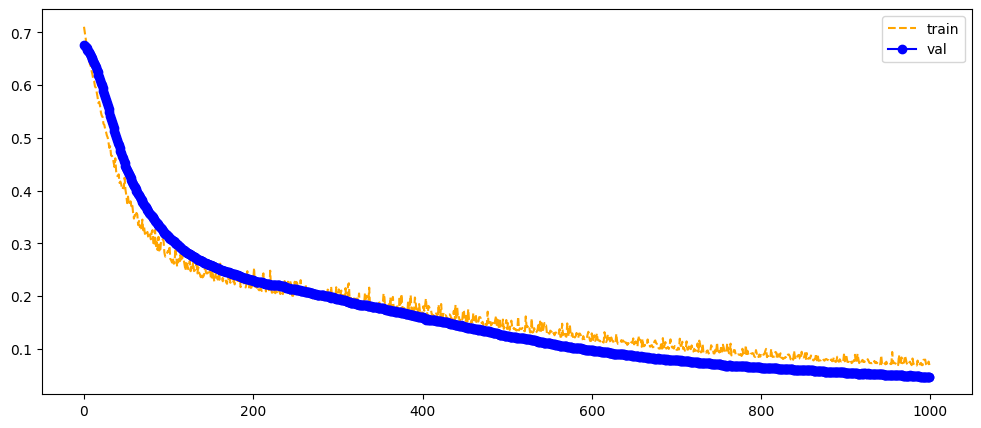

In [ ]:
def plot_loss(Loss_train, Loss_val):
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(Loss_train)), Loss_train, color='orange', label='train', linestyle='--')
    plt.plot(range(len(Loss_val)), Loss_val, color='blue', marker='o', label='val')
    plt.legend()
    plt.show()

plot_loss(clf.train_loss, clf.val_loss)

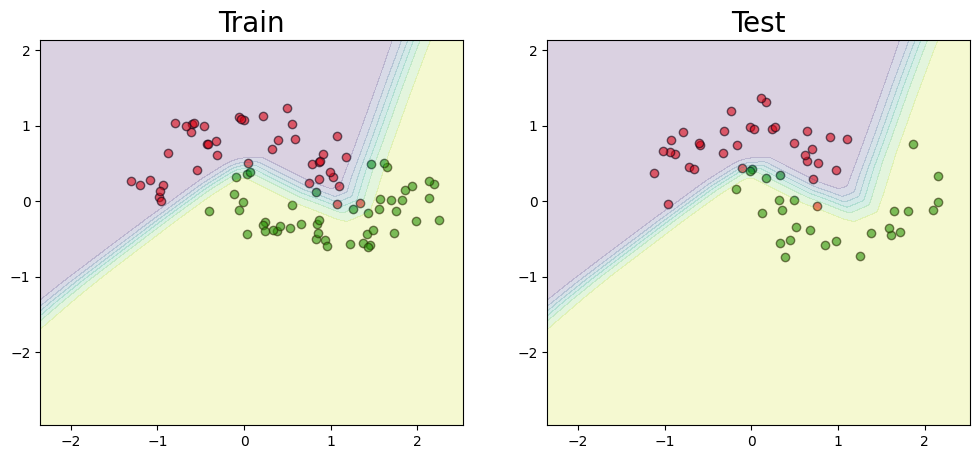

In [ ]:
def make_meshgrid(x1, x2, h=.02):
    x1_min, x1_max = x1.min() - 2, x1.max() + 2
    x2_min, x2_max = x2.min() - 2, x2.max() + 2
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    return xx1, xx2

def plot_contours(ax, xx1, xx2, **params):
    C = clf.predict(torch.Tensor(np.c_[xx1.ravel(), xx2.ravel()])).detach().numpy()
    C = C.reshape(xx1.shape)
    out = ax.contourf(xx1, xx2, C, **params)
    return out

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

xx1, xx2 = make_meshgrid(X[0], X[1])

ax1.scatter(X_train[:,0][y_train == 0], X_train[:,1][y_train == 0], c='red', marker='o', edgecolors = 'black', alpha = 0.6)
ax1.scatter(X_train[:,0][y_train == 1], X_train[:,1][y_train == 1], c='green', marker = 'o', edgecolors = 'black', alpha = 0.6)
ax1.set_title('Train', fontsize=20)
plot_contours(ax1, xx1, xx2, alpha=0.2)

ax2.scatter(X_test[:,0][y_test == 0], X_test[:,1][y_test == 0], c='red', marker='o', edgecolors = 'black', alpha = 0.6)
ax2.scatter(X_test[:,0][y_test == 1], X_test[:,1][y_test == 1], c='green', marker = 'o', edgecolors = 'black', alpha = 0.6)
ax2.set_title('Test', fontsize=20)
plot_contours(ax2, xx1, xx2, alpha=0.2);